In [6]:
# Vorgehen:
#     Definieren einer sehr einfachen MLP Architektur.
#     Anzahl der MLP Layer von 1 bis 3 durchlaufeun lassen.
#     Variable Anzahl Hidden Units pro Hidden Layer
#     Maximale Anzahl HU 500 (folgende sind immer absteigend, random search)
#     Keinen Drop-Out, kein Regularisierung. Konstante Hyperparameter. Selber Optimierer.

In [2]:
import pandas as pd
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import time

tfd = tfp.distributions

In [3]:
#plot function that is used later on for tracking training process
def plot(title, label, train_loss, val_loss):
    
    epoch_array = np.arange(len(train_loss)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(
        epoch_array, train_loss, epoch_array, val_loss, linestyle='dashed', marker='o'
        )
    legend = ['Train', 'Validation']

    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# Ausgeben ob mit GPU gibt
tf.debugging.set_log_device_placement(False)  #
# RAM für Berechnungen beschränken
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx("float64")

Num GPUs Available:  1


In [7]:
#location of simulated dataset (standardized version)
datapath = pathlib.Path('drive/MyDrive/simdata/fulldatasim_stand.csv')

In [8]:
dataset = pd.read_csv(datapath)

# ----------------------------------------  Daten bearbeiten  ---------------------------------------------

# datensatz durchwürfeln, um keine inhaltliche strutktur aufzuweisen
data = dataset.sample(frac=1)

#normalisierung von y
data[["norm_mPCS"]] = (data[["mPCS"]] - data[["mPCS"]].mean()) / (
    data[["mPCS"]].max() - data[["mPCS"]].min()
)

In [9]:
## Data Split nach: 80/20
# 80% als Train und validation:
train = data[0 : int(len(data) * 0.8)]
# 20% als Testing:
test = data[int(len(data) * 0.8) : int(len(data))]

# Sicherheitshalber x und y aufteilung nachbauen.
# Sicher ist sicher und ich bin zu faul zum debuggen.
x_train = train.iloc[:, 0:11]
y_train = train.iloc[:, 12]
x_test = test.iloc[:, 0:11]
y_test = test.iloc[:, 12]

# Umformen in TensorFlow Tensoren aus Verlässlichkeit
# Train:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
# Test
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [10]:
# How large is the dataset?
N = len(dataset.index)
# number of epochs to train the model for
num_epochs = 30
# how many variables
input_units = 11
# define batch size for training
batch_size = 256
# maximum number of hidden units for random search
max_hidden_units = 500
# learning rate
lr = 0.001
# number hidden layers
num_hidden_layers = 3

In [16]:
#make list for random search of number of hidden units
num_sets = 30 #how many sets to try
hu_list = []

for k in range(num_sets):
  curr_max = max_hidden_units
  curr_hu = []
  for i in range(num_hidden_layers):
    rd_int = np.random.randint(5, curr_max)
    curr_max = rd_int
    curr_hu.append(rd_int)
  hu_list.append(curr_hu)

In [17]:
# ---------------------------------------------------------------------------------------------------------
# ---------------------------------------------  Model   --------------------------------------------------
# ---------------------------------------------------------------------------------------------------------

# ---------------------------------------------   Loss   --------------------------------------------------

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [18]:
class DDR_MLP(tf.keras.Model):
  def __init__(self, num_hidden_layers, num_hidden_units, activation_fun = "relu"):
    super(DDR_MLP, self).__init__()
    self.num_hidden_layers = num_hidden_layers
    self.num_hidden_units = num_hidden_units
    self.act_fun = activation_fun


    #check for valid combination of hidden unit list and number of hidden layers
    if isinstance(self.num_hidden_units, int):
      self.num_hidden_units = np.full(self.num_hidden_layers, self.num_hidden_units)
    elif self.num_hidden_layers > len(self.num_hidden_units):
      raise ValueError("not enough values of hidden units supplied") 


    ##### model architecture #####
    #setup and input layer
    self.arch = tf.keras.Sequential()
    self.arch.add(tf.keras.layers.InputLayer(input_shape=(11)))

    #add hidden layers
    for i in range(self.num_hidden_layers):
      self.arch.add(tf.keras.layers.Dense(self.num_hidden_units[i], activation='relu'))

    #output layers
    self.arch.add(tf.keras.layers.Dense(2))
    self.arch.add(tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t[..., 0],
                              scale= tf.exp(t[..., 1]))))

  def call(self, inputs):
    x = self.arch(inputs)
    return x


In [19]:
def run_training(model, 
                 x = x_train, y = y_train, 
                 loss_fun = negloglik,
                 num_epochs = num_epochs, 
                 batch_size = batch_size,
                 lr = lr, 
                 optim = tf.keras.optimizers.Adam):
  
  #compile model
  model.compile(optimizer = optim(learning_rate = lr),
                loss = loss_fun,
                metrics = [tf.keras.metrics.MeanSquaredError()])
  
  #train model
  mfit_history = model.fit(x = x, y = y, 
                           batch_size = batch_size,
                           epochs = num_epochs, verbose=False, 
                           validation_split = 0.25)

  return model, mfit_history

In [30]:
def model_diagnostics(model, mfit_history):

  #get losses and MSE over epochs
  train_loss = mfit_history.history['loss']
  valid_loss = mfit_history.history['val_loss']
  train_mse = mfit_history.history['mean_squared_error']
  valid_mse = mfit_history.history['val_mean_squared_error']

  losses = pd.DataFrame({'train': train_loss, 'valid': valid_loss})
  mses = pd.DataFrame({'train': train_mse, 'valid': valid_mse})

  #predict with model(), as model.predict() doesn't work with last layer
  predictions = model(np.array(x_train))

  return losses, mses, predictions

In [78]:
#model.arch.summary()

#2 Hidden Layers

In [21]:
batch_train_losses = []
batch_valid_losses = []
batch_train_mses = []
batch_valid_mses = []
predictions = []

for hu in hu_list:
  model = DDR_MLP(
      num_hidden_layers = 2,
      num_hidden_units = hu
      )
  model, mfit_history = run_training(model = model,
                                     x=x_train,
                                     y=y_train,
                                     loss_fun=negloglik,
                                     num_epochs=25,
                                     batch_size=batch_size,
                                     lr=lr,
                                     optim=tf.keras.optimizers.Adam)
  
  #append metrics to result arrays
  batch_train_losses.append(mfit_history.history['loss'])
  batch_valid_losses.append(mfit_history.history['val_loss'])
  batch_train_mses.append(mfit_history.history['mean_squared_error'])
  batch_valid_mses.append(mfit_history.history['val_mean_squared_error'])

  predictions.append(model(np.array(x_train)))

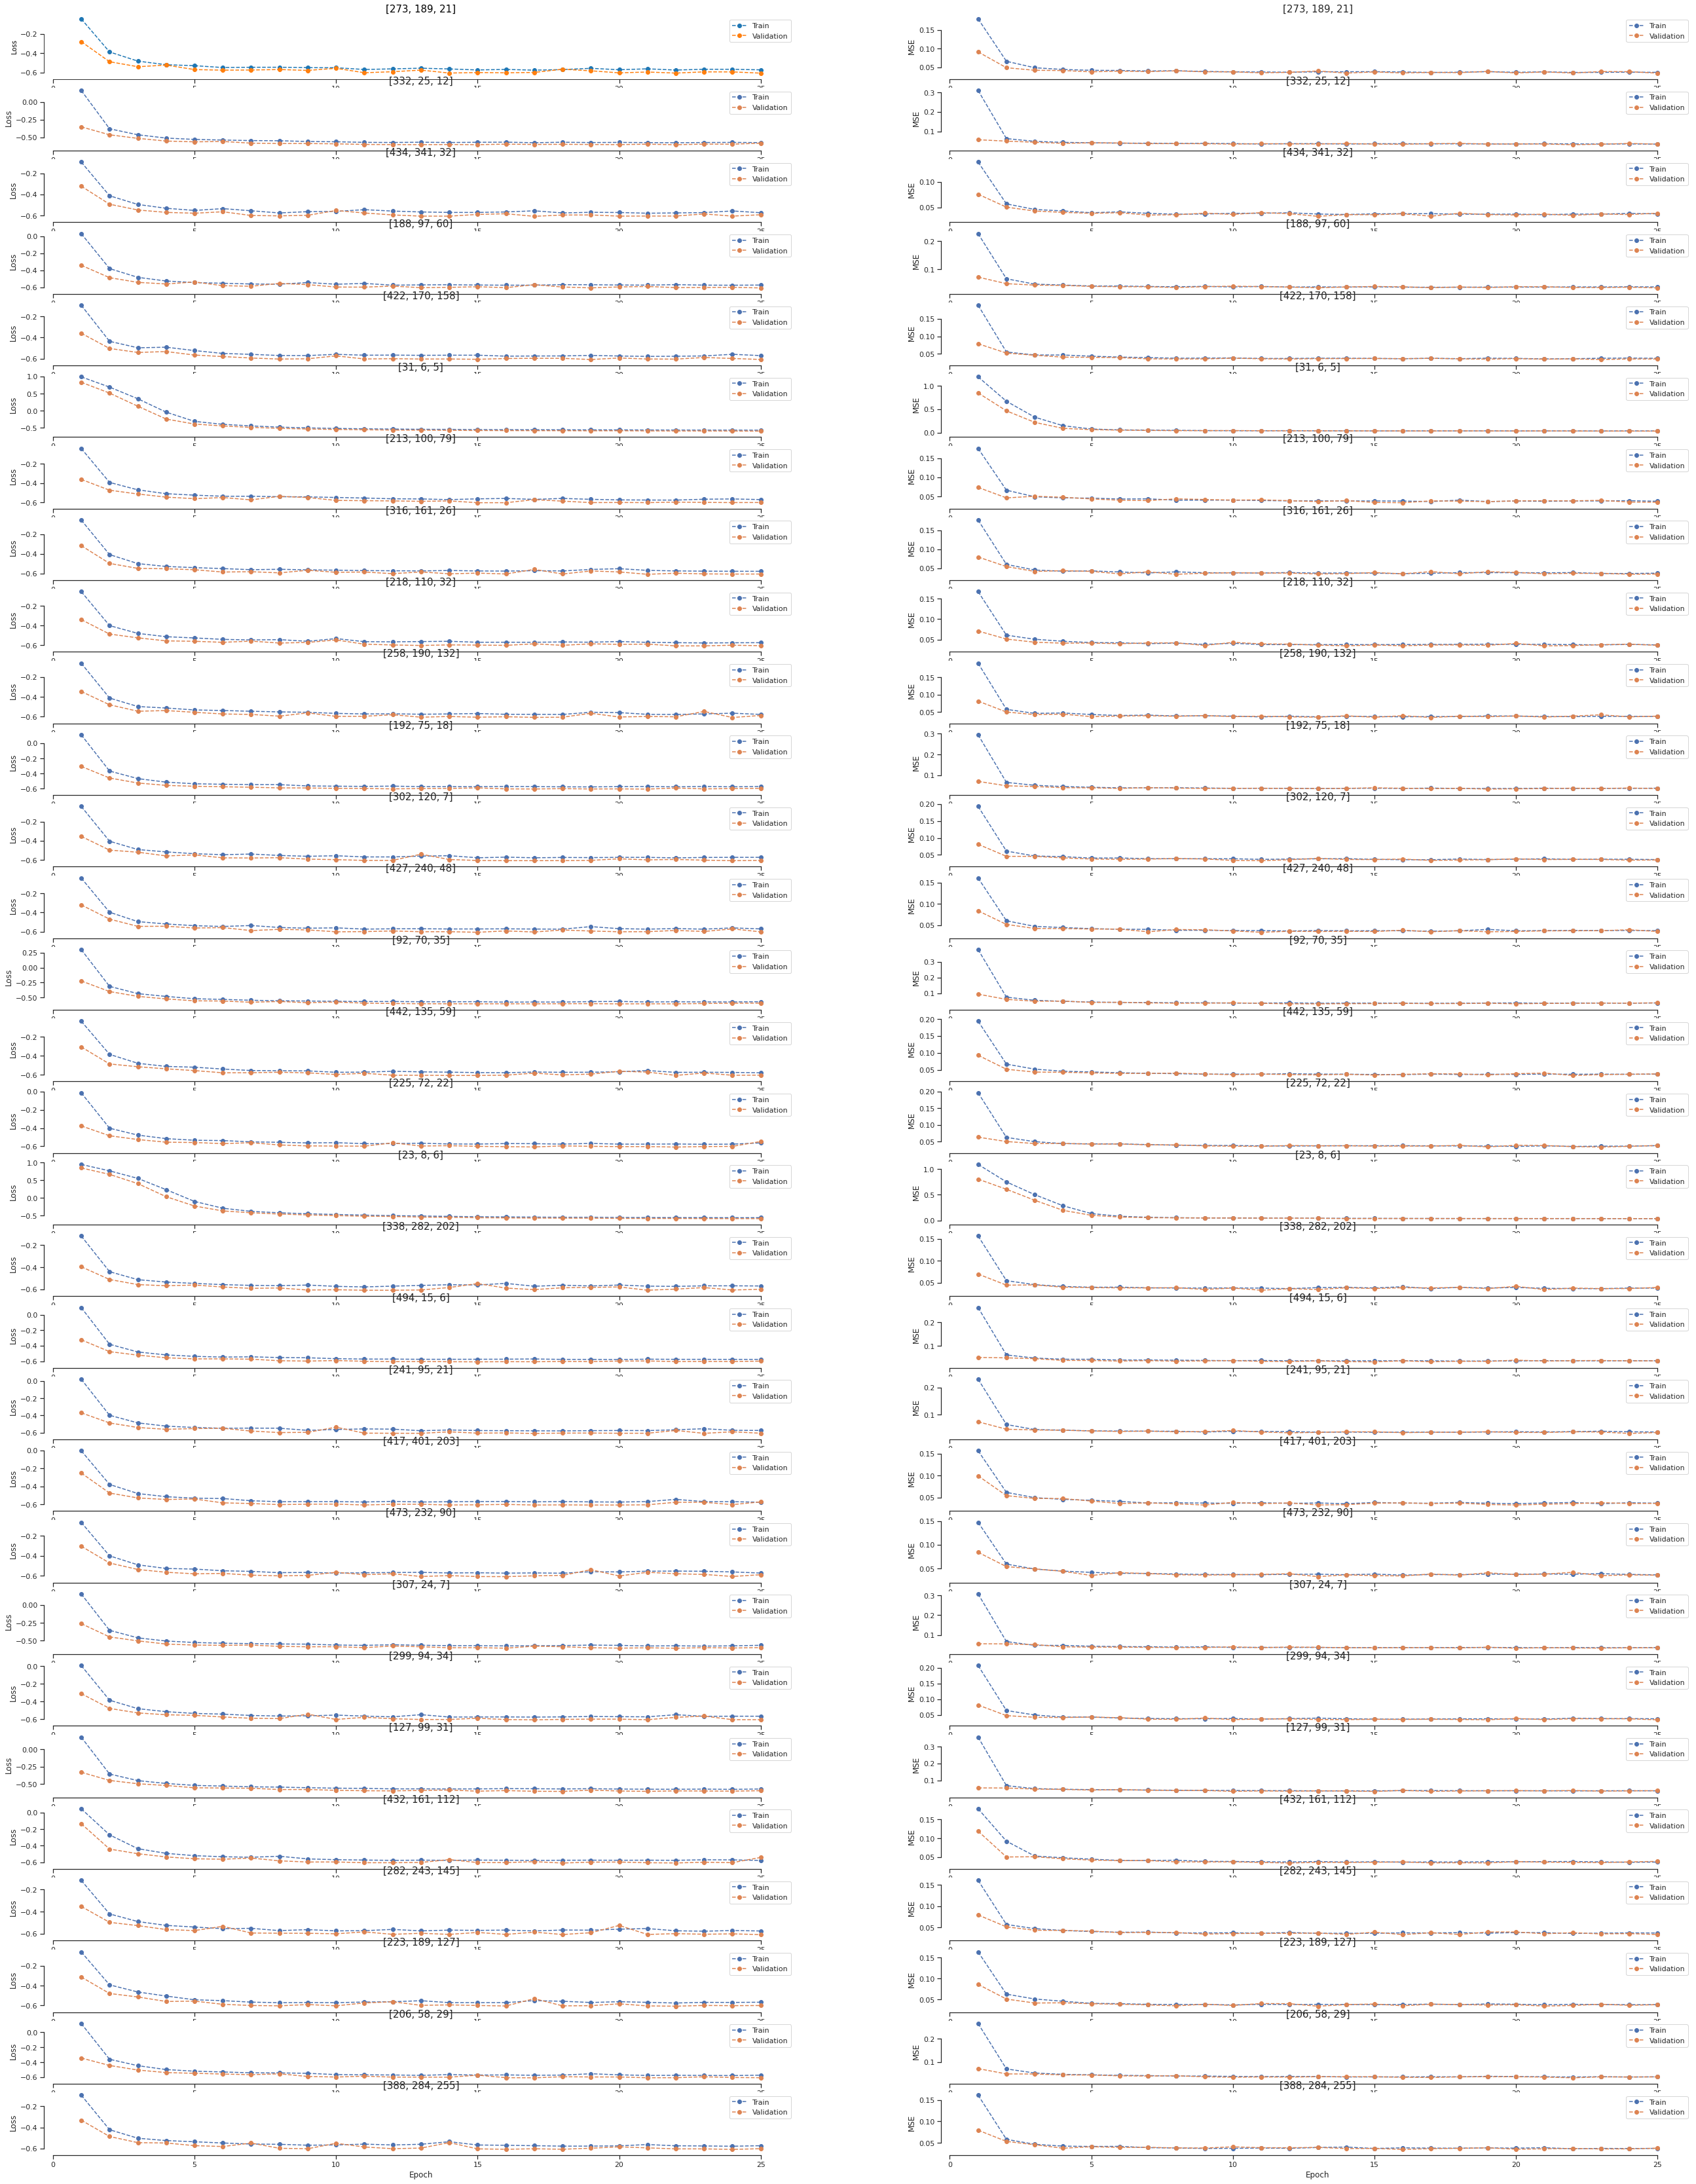

In [22]:
f = plt.figure()
f.set_figwidth(45)
f.set_figheight(60)

k = 0
for i in range(len(hu_list)):
    k += 1
    plt.subplot(len(hu_list), 2, k)
    plot(str(hu_list[i]), "Loss", batch_train_losses[i], batch_valid_losses[i])
    k += 1
    plt.subplot(len(hu_list), 2, k)
    plot(str(hu_list[i]), "MSE", batch_train_mses[i], batch_valid_mses[i])

Text(0.5, 1.0, 'True Values')

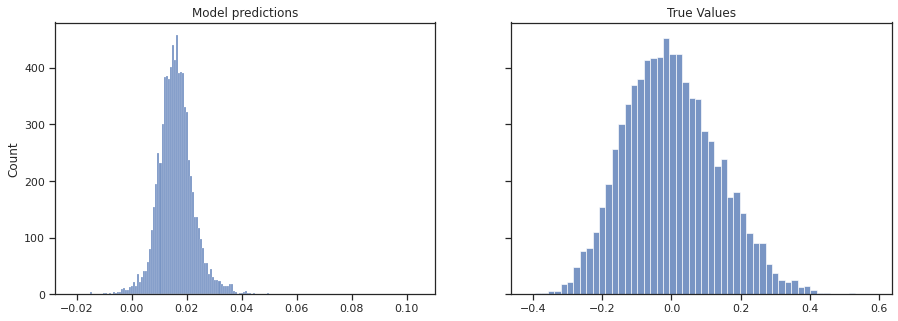

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[10].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

#3 Hidden Layers

In [35]:
batch_train_losses = []
batch_valid_losses = []
batch_train_mses = []
batch_valid_mses = []
predictions = []

for hu in hu_list:
  model = DDR_MLP(
      num_hidden_layers = 3,
      num_hidden_units = hu
      )
  model, mfit_history = run_training(model = model,
                                     x=x_train,
                                     y=y_train,
                                     loss_fun=negloglik,
                                     num_epochs=25,
                                     batch_size=batch_size,
                                     lr=lr,
                                     optim=tf.keras.optimizers.Adam)
  
  #append metrics to result arrays
  batch_train_losses.append(mfit_history.history['loss'])
  batch_valid_losses.append(mfit_history.history['val_loss'])
  batch_train_mses.append(mfit_history.history['mean_squared_error'])
  batch_valid_mses.append(mfit_history.history['val_mean_squared_error'])

  predictions.append(model(np.array(x_train)))

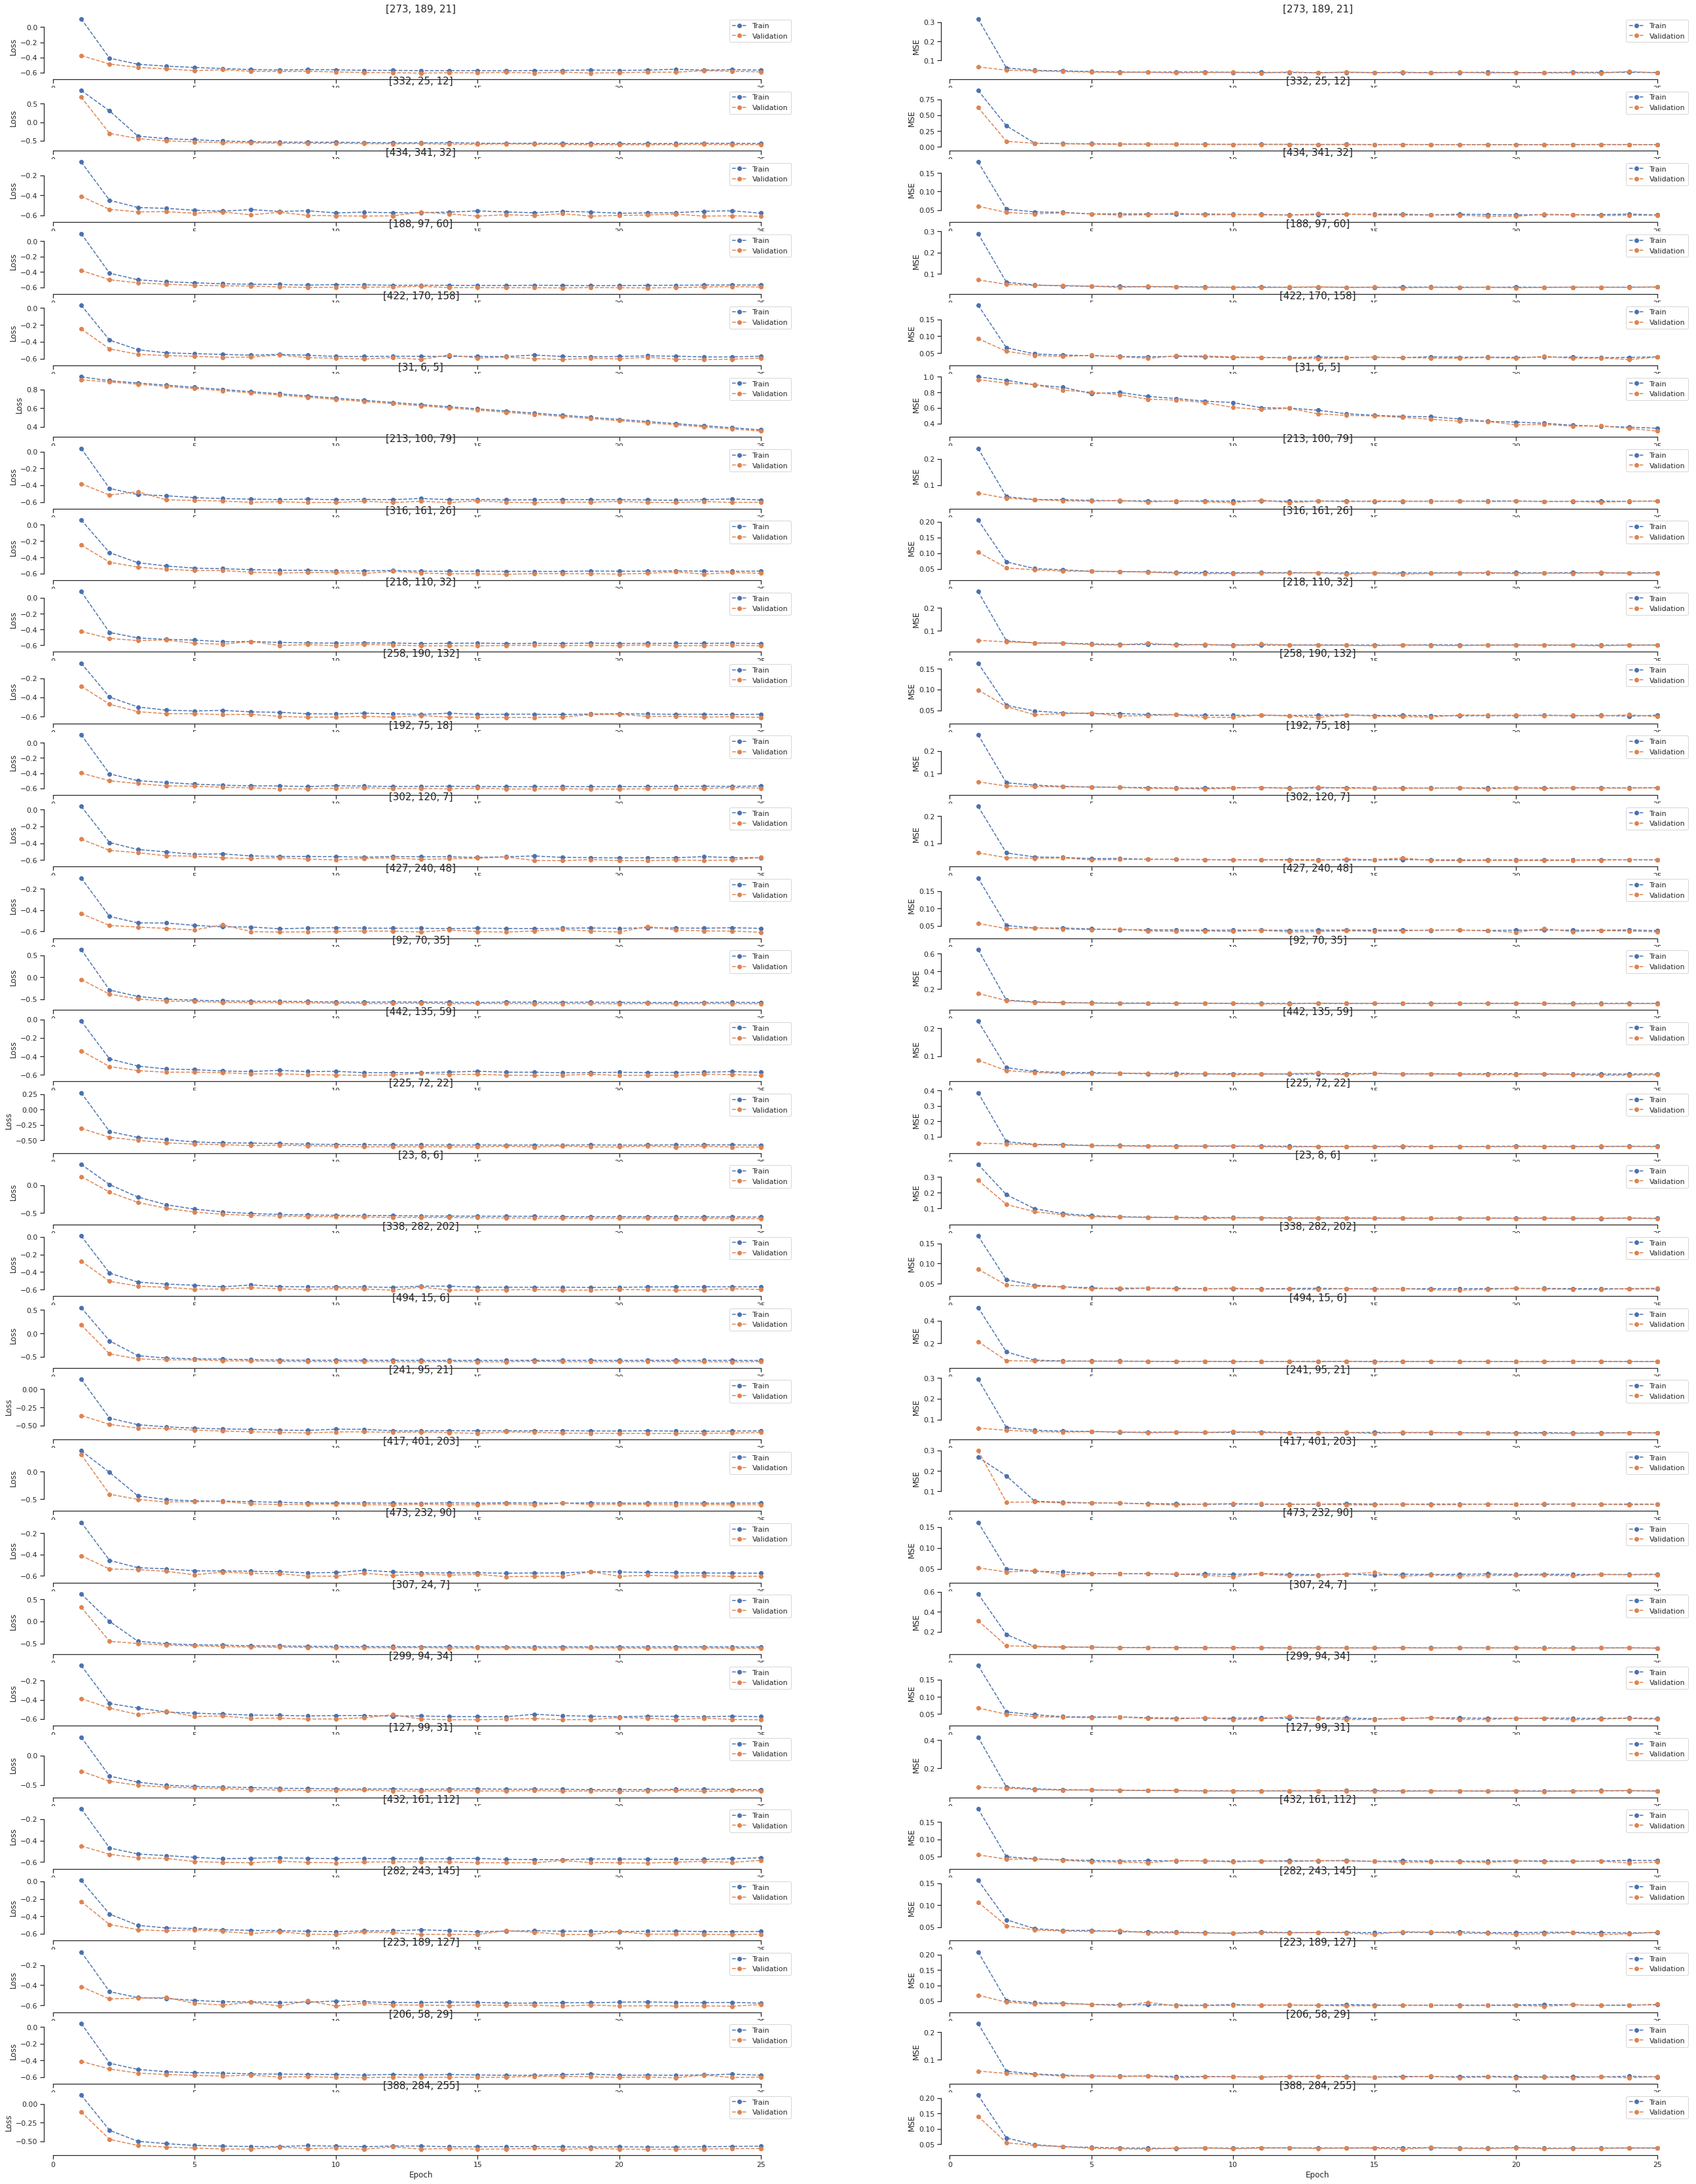

In [36]:
f = plt.figure()
f.set_figwidth(45)
f.set_figheight(60)

k = 0
for i in range(len(hu_list)):
    k += 1
    plt.subplot(len(hu_list), 2, k)
    plot(str(hu_list[i]), "Loss", batch_train_losses[i], batch_valid_losses[i])
    k += 1
    plt.subplot(len(hu_list), 2, k)
    plot(str(hu_list[i]), "MSE", batch_train_mses[i], batch_valid_mses[i])

Text(0.5, 1.0, 'True Values')

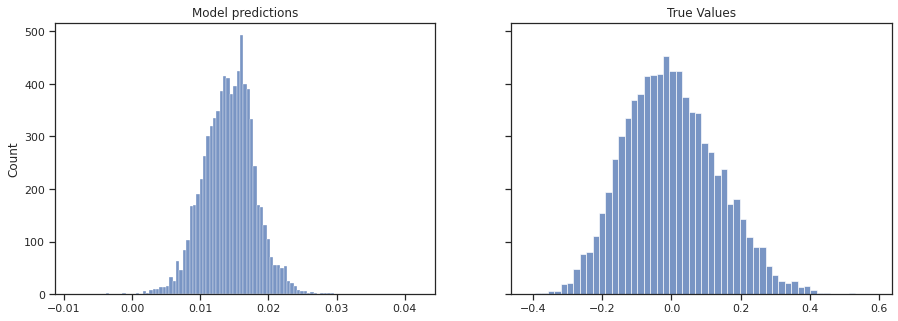

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[20].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train)
axes[1].set_title('True Values')

#Overfit on small sample?

In [31]:
batch_train_losses = []
batch_valid_losses = []
batch_train_mses = []
batch_valid_mses = []
predictions = []

for hu in hu_list[1:5]:
  model = DDR_MLP(
      num_hidden_layers = 3,
      num_hidden_units = hu
      )
  model, mfit_history = run_training(model = model,
                                     x=x_train[1:100],
                                     y=y_train[1:100],
                                     loss_fun=negloglik,
                                     num_epochs=25,
                                     batch_size=50,
                                     lr=lr,
                                     optim=tf.keras.optimizers.Adam)
  
  #append metrics to result arrays
  batch_train_losses.append(mfit_history.history['loss'])
  batch_valid_losses.append(mfit_history.history['val_loss'])
  batch_train_mses.append(mfit_history.history['mean_squared_error'])
  batch_valid_mses.append(mfit_history.history['val_mean_squared_error'])

  predictions.append(model(np.array(x_train[1:100])))

Text(0.5, 1.0, 'True Values')

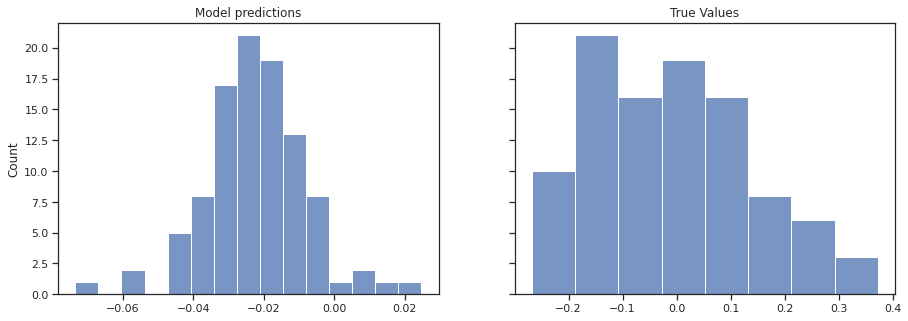

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# predictions
sns.histplot(ax=axes[0], x = predictions[2].loc)
axes[0].set_title('Model predictions')

# true values
sns.histplot(ax=axes[1], x = y_train[1:100])
axes[1].set_title('True Values')